### Applying the T-SNE on Amazon reviews with polarity based color-coding

This is an Amazon Product Reviews Dataset

We have to Anaylyse the reviews and plot them Positive/Negative  review points based color coding.

Author : Praveen K

### Attributes/Features Information

Data Source: https://www.youtube.com/watch?v=WSuOtoN5L4Q

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of Datapoints: 568,454

Attribute Information:

Id
ProductId - unique identifier for the product

UserId    - unqiue identifier for the user

ProfileName

HelpfulnessNumerator   - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score                  - rating between 1 and 5

Time                   - timestamp for the review

Summary                - brief summary of the review

Text                   - text of the review


### Objective:
Using the T-SNE, Plotting on the given reviews text in such a way that we can distinguish  positive and 
negative reviews significantly.

### Assumptions

I am only working with 2000 Data points due the computiational issue.

positive (Rating of 4 or 5) or negative (rating of 1 or 2) and We will not be processing the rating 3.


### Note - Source code

### Prerequisites 

In [52]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
import pickle

I have imported all the required packages above, still if anything needed we will import them as and when required.

### Data Loading

Dataset is there in my local system in table format in a file called Database.sqlite.

Firstly I am establishing the sql connection to the Database file.

Using the 'pandas' we retrieve the data from the table callled Reviews and create and Data Set

In [191]:
conn =  sqlite3.connect("database.sqlite")
Amazon_Data_Raw = pd.read_sql_query(""" select * from Reviews WHERE Score != 3 """, conn)

In [190]:
print(Amazon_Data_Raw.size)
print(Amazon_Data_Raw.shape)

5258140
(525814, 10)


we have the size  with  '5258140' data points and '10' features

### Preprocessing

#DataCleansing 

1. Delete Duplicates
   Let us delete the duplicate set of fileds like 'UserId','ProfileName', 'Time' and also  'Text'.
   Because 'UserId','ProfileName', 'Time' should be unique for any user review. 
   And also there is no use of processing a review 'Text' for more than once 

In [54]:
Amazon_Data_Raw = Amazon_Data_Raw.drop_duplicates(subset = {'UserId','ProfileName', 'Time', 'Text'}, keep='first' , inplace = False)
Amazon_Data_Raw.size

3641730

Note :
More that 30% of Unwanted data has been removed.

#DataCleansing

2.We should not process the record if HelpfulnessDenominator greater than HelpfulnessNumerator,
  Since it is not correct.

In [55]:
Amazon_Data_Raw.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [56]:
Amazon_Data = Amazon_Data_Raw[Amazon_Data_Raw.HelpfulnessNumerator <= Amazon_Data_Raw.HelpfulnessDenominator]
print(Amazon_Data.size)

3641710


Note : 
 We have removed 20 unwanted/Invalid records form the Dataset.



#### Determine the Dependent and Independent features from the Dataset

In [57]:
# We are only processing the 5000 records due the computational issues
Amazon_Data = Amazon_Data.head(5000)
Amazon_Data_Y = Amazon_Data['Score']
print(Amazon_Data.shape)

(5000, 10)
(2000, 10)


Now, Let us focus on the Actuall Processing, as our major objective is to plot the Amazon Reviews.

In such a way that we can differentiate positive and negative reviews out the 

In [60]:
Amazon_Data.shape

(5000, 10)

Here in the Dataset, feature "Score" is in Numbers like 1,2,4,5 

let us just convert it into Categorical feautre where 1,2 represents the Negative Reviews and 4,5 represents the Positive Reviews.


In [63]:
Amazon_Data['Score'].head(5)

0    5
1    1
2    4
3    2
4    5
Name: Score, dtype: int64

In [64]:
def Conv_To_Catg(x):
    if (x<3):
        return 'Negative'
    else:
        return 'Positive'

In [65]:
PositiveNegative= Amazon_Data['Score'].map(Conv_To_Catg)
Amazon_Data['Score']  = PositiveNegative
PositiveNegative.value_counts()

Positive    4189
Negative     811
Name: Score, dtype: int64

We have converted the Score from numerical values to Categorical with Positive and Negative.

In [66]:
Amazon_Data_Y = PositiveNegative   #Dependent Feature
print(Amazon_Data.shape)      #InDependent Feature shape
print(Amazon_Data_Y.shape)    #InDependent Feature shape

(5000, 10)
(5000,)


In [67]:
i=0
for sent in Amazon_Data['Text']:
    if (len(re.findall('<.*?>',sent))):
        i+=1    
if i>0:
    print("Text feature contins the Html tags inside the reviews")

Text feature contins the Html tags inside the reviews


#### DataCleansing


Let us Focus On the Core Part of our Objective, that is Reviews/Text Analysis

If we observe the Feature "Text" in the our dataset.

There are some html tags included in the reviews which are unnecessary for us to analyse.

And also there might other puncutations or specail characters which are not required to get insights out of it.

Later we also check wheather the word belongs to english word or not and it does not contain any numbers in it

There might be some words or letters in uppercase to keep everythin similar lets make a everything lowercase letters


For that matter we follow the below steps


    1. Begin by removing the html tags
    2. Remove any punctuations or limited set of special characters like , or . or # etc.
    3. Check if the word is made up of english letters and is not alpha-numeric
    4. Check to see if the length of the word is greater than 2(as it was researched that there is no adjective in 2-letters)
    5. Convert the word to lowercase
    6. Remove Stopwords
    7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [69]:
stop = set(stopwords.words('english')) 
sno = SnowballStemmer('english')

STOPWORDS::

stopwords words are the set of words provided by the natural language tool kit.

These are the words which will not carry any weight to get the meaning of the words.

Moreover these words are said to be the helping words to form a meaningful sentence.


STEMWORDS:

These are the roots words of the english words.

For many words in english can have only semanitc meaning.

This will helps us the eleminate duplicates of the words in roots level.

Also can helps us to limit the no of unique words in forming a n-dimensinal vector

In [70]:
print(stop)
print("****************")
print(" ")
print(" ",sno.stem('good'))
print(" ",sno.stem('delicious'))

{'their', 'during', 'but', 'herself', 'below', 'more', "didn't", "weren't", 'they', 'being', 'between', 'his', 'am', 'our', 'until', "doesn't", 'other', 'o', 'wasn', 'himself', 'here', 'nor', 'such', 'was', 'were', 'if', 'are', 'y', 'ma', 'where', 'don', 'yours', 'both', 'should', 'that', 'under', 'my', "won't", 'before', 'why', 't', 'there', 'of', 'a', 'doing', 'will', 'couldn', 'him', 'doesn', 'ours', 'than', "wasn't", 'your', 'as', 'after', 'now', 'hadn', "needn't", 'which', 'when', 'each', 'does', 'no', 'again', 'she', 'd', 'aren', 'i', 'too', "couldn't", 'mightn', "shan't", "wouldn't", 'to', 'for', 'few', 'shan', 'at', 'not', "shouldn't", 'shouldn', "it's", 's', 'just', 'm', 'and', "that'll", "she's", 'wouldn', 'about', 'itself', 'had', 'needn', 'mustn', 'further', 'those', 'while', 'into', 'myself', "mustn't", 'most', 'ourselves', 'it', 'who', 'be', 'hers', "hadn't", "aren't", 'through', 'did', "mightn't", 'hasn', 'theirs', 'whom', "you'd", 'having', 'weren', 'only', 'its', "don'

In [71]:
#Function to clean Html tags
def cleanHtml(x):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ', x)
    return cleantext
def cleanPunc(x):
    cleantext = re.sub(r'[?|!|\'|"|#]', r' ', x)
    cleanall = re.sub(r'[.|,|)|(|\|/|<|>]',r'',cleantext)
    return cleantext

Above functions are to clean the sentence and words.

If they consists htmls tags or any special characters we clean them either removing or replacing with space.

#### Preprocessing

In [76]:
clean_review_doc=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[]  # store words from -ve reviews here.
for i,sent in enumerate(Amazon_Data['Text'].values):      
    cleaned_sentence_list = []
    sentence = cleanHtml(sent)
    for words in sentence.split():
        for cleaned_word in cleanPunc(words).split():
            if (cleaned_word not in stop):
                if (cleaned_word.isalpha()) & (len(cleaned_word)>2):                    
                    cleaned_word = cleaned_word.lower()
                    stem_word = (sno.stem(cleaned_word)).encode('utf8')
                    cleaned_sentence_list.append(stem_word)                    
                    if (Amazon_Data['Score'].values)[i] == 'Positive':
                        all_positive_words.append(stem_word)
                    if (Amazon_Data['Score'].values)[i] == 'Negative':
                        all_negative_words.append(stem_word)
    temp_str = b" ".join(cleaned_sentence_list)
    clean_review_doc.append(temp_str)   #list with each review as an elemen t.
    #pdb.set_trace()    

Here in above code we have converted the reviews into the list of each review as an element

In [77]:
Amazon_Data['CleanReview'] = clean_review_doc
Amazon_Data['CleanReview'] = Amazon_Data['CleanReview'].str.decode('utf-8')

We are storing the list of reviews as new feature 'CleanReview' to our existed Dataset

##### Store The Processed Output  In our Local
1.We are done with the Pre-processing of the data
Let store the final version of the Cleaned Amazon dataset in our local.
So that,we will have the data ready for our future actions 


2.Let's also save the Postive and Negative words, which we have collected while getting the stem words in our local Pickle files.

In [78]:
conn = sqlite3.connect('Cleaned_Amazon_Data.sqlite')
Amazon_Data.to_sql('Reviews',conn,schema= 'None',if_exists= 'replace',\
            index=True,index_label=None,chunksize=None,dtype=None)
conn.close()

In [79]:
#Positive Words
with open('Cleaned_positive_words.pkl', 'wb') as f:
    pickle.dump(all_positive_words,f)
f.close()

In [80]:
#Negative Words
with open('Cleaned_negative_words.pkl','wb') as f:
    pickle.dump(all_negative_words,f)
f.close()

We have storted the Cleaned review dataset as a SQL table in Cleaned_Amazon_Data.sqlite files

Using the Pickle-package

        we stored the Positive stems words in a file called Cleaned_positive_words.pkl
        
        Also stored the Negative stems words in a file Cleaned_negative_words.pkl

### Retrive
Retrive the data from the Stored Tables and Files 

In [81]:
import os
if os.path.isfile('Cleaned_Amazon_Data.sqlite'):
    conn =  sqlite3.connect('Cleaned_Amazon_Data.sqlite') 
    Amazon_Db = pd.read_sql_query("""select * from Reviews """, conn) #WHERE Score != 3
    print("Retried the Dataset from the Tables")
    conn.close()            
else:
    print("Please the above cell")

Retried the Dataset from the Tables


In [82]:
print(Amazon_Db.columns)

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanReview'],
      dtype='object')


#### Get the Bag Of Words

Let's create the Bag Of Words on our newly created feauture 'CleanReview' with n_gram_range equal to 1.

To create bag of words we use CountVectorizer from sklearn.

It will results you a d-dimensional sparse Vector with the each unique word from the corpus as each dimensions.

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
CountVect = CountVectorizer()

In [69]:
bog_onegrams = CountVect.fit_transform(Amazon_Db['CleanReview'].values)

In [70]:
bog_onegrams

<5000x7719 sparse matrix of type '<class 'numpy.int64'>'
	with 130938 stored elements in Compressed Sparse Row format>

We got the Sparse Matrix with the size of 5000 x 7719

That means for all our 5000 review we got the uniqu vector of 7719 dimensions, with most of its elements as zeor's

In [71]:
print("the type of count vectorizer ",type(bog_onegrams))
print("the shape of out text BOW vectorizer ",bog_onegrams.get_shape())
print("the number of unique words including both unigrams and bigrams ", bog_onegrams.get_shape()[1])
print("the number of unique words including both unigrams and bigrams ", bog_onegrams[0:1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 7719)
the number of unique words including both unigrams and bigrams  7719
the number of unique words including both unigrams and bigrams    (0, 614)	1
  (0, 308)	1
  (0, 2529)	1
  (0, 3727)	1
  (0, 6161)	1
  (0, 4136)	1
  (0, 5240)	1
  (0, 6439)	1
  (0, 3869)	1
  (0, 3940)	1
  (0, 6812)	1
  (0, 2895)	1
  (0, 2658)	1
  (0, 5245)	3
  (0, 2617)	1
  (0, 1984)	1
  (0, 962)	1
  (0, 7364)	1
  (0, 5975)	1
  (0, 760)	1


In [72]:
bog_onegrams_dense = bog_onegrams.toarray()
print("Amazon_bigrams >>", bog_onegrams_dense)

Amazon_bigrams >> [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


To use this sparse matrix for our further processing we have converted it into Dense Vector

In [73]:
Amazon_Db['Score'].value_counts()

Positive    4189
Negative     811
Name: Score, dtype: int64

In [74]:
np.unique( Amazon_Db['Score'])

array(['Negative', 'Positive'], dtype=object)

In the Label we have two classes firtst one is Positive with 4189 points

and the other one is Negative with 811 points

So Here, we are trying to plot 5000 reviews with respective to theri class lables. 

Such that we can distinguish positive and Negative Reviews.

For that matter we have to reduce dimensionality of the "reviews BagOfWords Matrix" , from 5000 x 7719 to 5000 x 2

### T-SNE

As we are trying to visualize the data in 2D, T-SNE  is the best techqique to to reduce the dimensionality and also to visualize the data

For this we have intialized the TSNE with the parametres like n_components, random_state , n_iter

n_components: 

It is the input which tell the number of coridinates that we want plot. 

perplexity:

   As TSNE is random state Algorimth, by default it has a nature of adjusting the data points.
   if the data points are very dense then adjust to sparse data points whereas sparse data points to dense 
 
n_iter:

   TSNE may change the ploting for each iteration.
   For getting the better results, we will give you the maximum iterations
               

In [75]:
from sklearn.manifold import TSNE

In [76]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)

###### Applying the TSNE on Perplexity 5

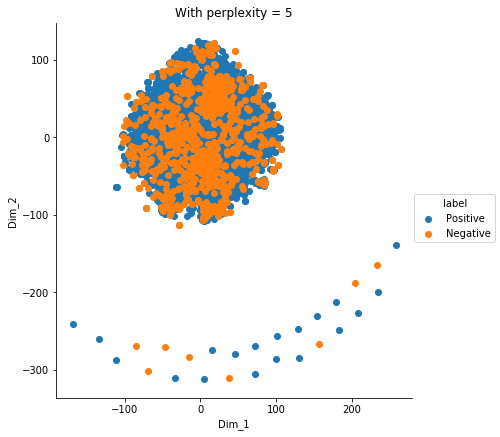

In [77]:
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

Observations:

We have given the BagofWords Review Matrix to Tsne with perplexity equal to '5' for 5000 iterations.

We got the data in two formats, one is rounded which includes both Positive and Negative.

Later is the two curved lines like structure with both positive Points

We can not find any visual difference to draw a decision surface between Positve and negative reviews.

Since the TSNE is a randmized algorithm, let us try to run for the same program with the same parametres

Let us run with the same input for the second time also


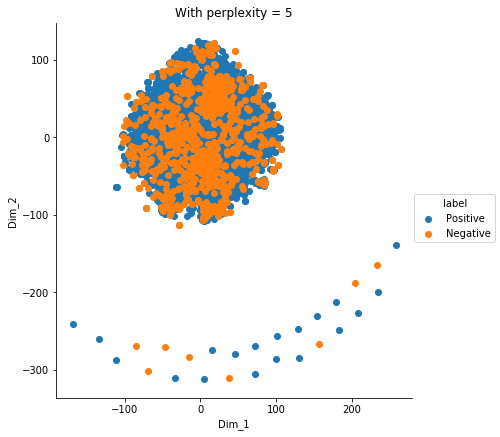

In [78]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

Observations:
    
I don't find any major differce from the previous run ouput.

##### Applying the TSNE on Perplexity 10

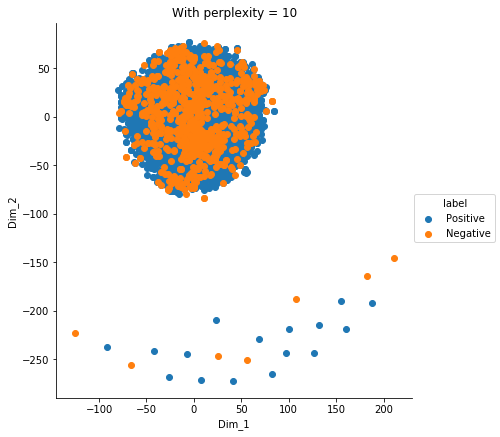

In [79]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

Observation:

We have given the BagofWords Review Matrix to Tsne with perplexity equal to '10' for 5000 iterations.

We got the data in two formats, one is rounded which includes both Positive and Negative. But this is little Densed that previous.

Later, some points are foroming a curved like structure tending upwards, contains both positive and Negative Points

We can not find any visual difference to draw a decision surface between Positve and negative reviews.

Since the TSNE is a randmized algorithm, let us try to run for the same program with the same parametres

Let us run with the same input for the second time also

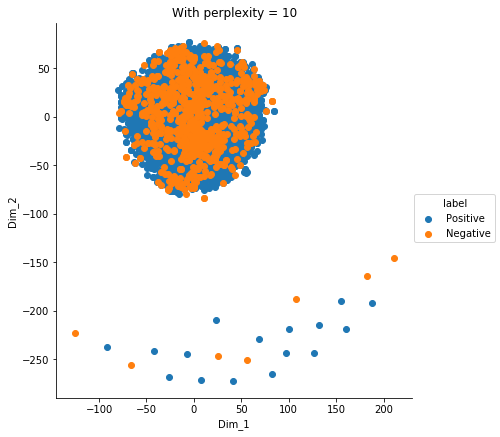

In [80]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

###### Applying the TSNE on Perplexity 20

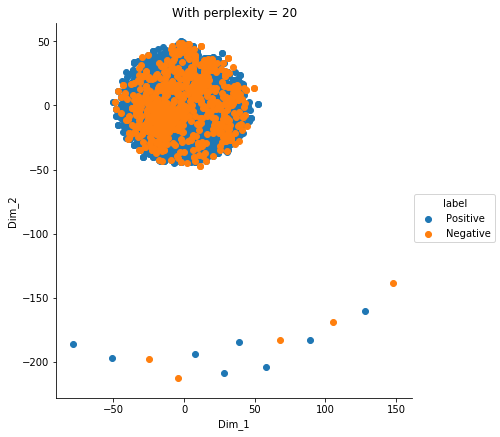

In [82]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

Observation:

We have given the BagofWords Review Matrix to Tsne with perplexity equal to '20' for 5000 iterations.

We got the data in two formats, one is rounded which includes both Positive and Negative. But this is little More Denser than the previous.

Later, few pionts are foroming a two curved like structure tending upwards includes positive and Negative Points equally

We can not find any visual difference to draw a decision surface between Positve and negative reviews.

Since the TSNE is a randmized algorithm, let us try to run for the same program with the same parametres

Let us run with the same input for the second time also

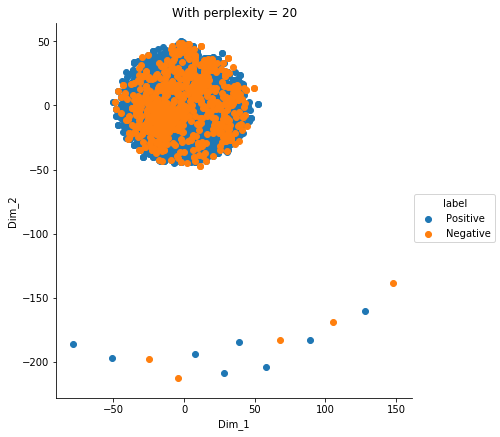

In [83]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

In [84]:
#Now,we will try to run T-sne on th eBagofWords Review Matrix --> with perplexity equal to '30' for 5000 iterations

###### Applying the TSNE on Perplexity 30

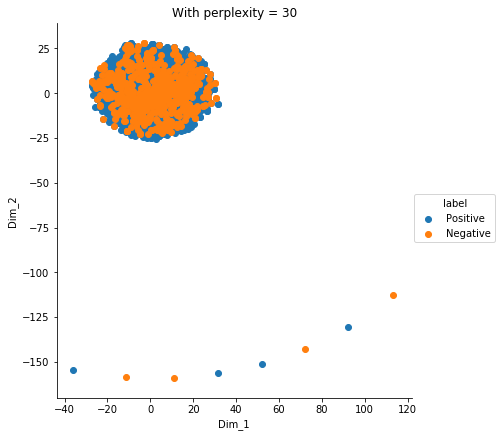

In [85]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

Observation:

We got the data in two figures, one is rounded which includes both Positive and Negative.

But this time, round part is very Denser than all our previous runs.

Later, a very few pionts are formed a single line tending upwards, includes positive and Negative Points equally

We can not find any visual difference to draw a decision surface between Positve and negative reviews.


let's run the same for the second time (preplexity is 30)

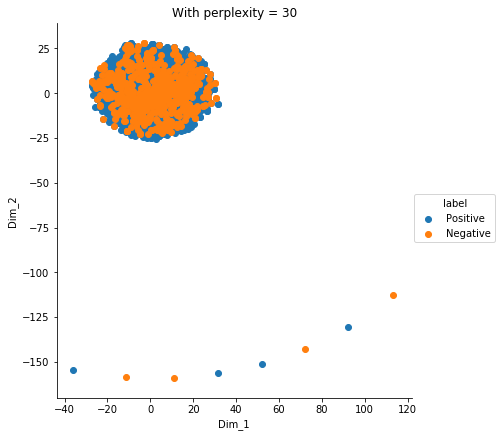

In [86]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

In [88]:
#Now,we will try to run T-sne on th eBagofWords Review Matrix --> with perplexity equal to '40' for 5000 iterations

###### Applying the TSNE on Perplexity 40

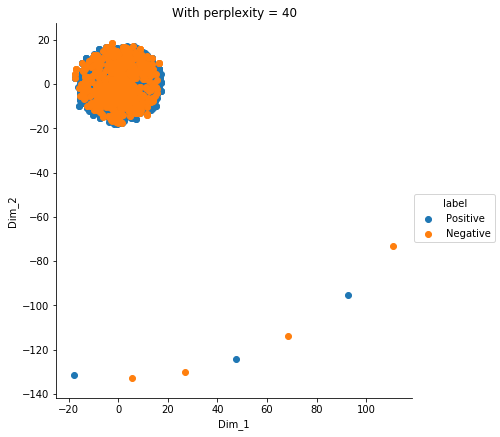

In [89]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

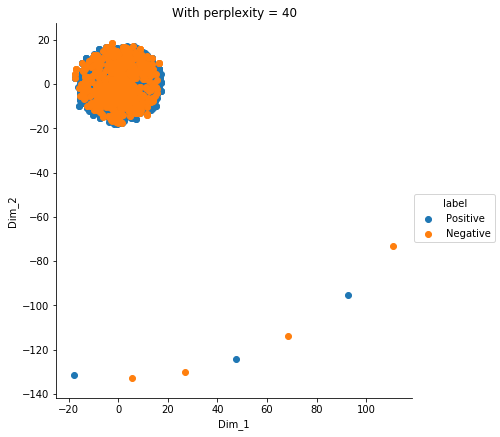

In [90]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

Now,we will try to run T-sne on th eBagofWords Review Matrix --> with perplexity equal to '50' for 5000 iterations

###### Applying the TSNE on Perplexity 50

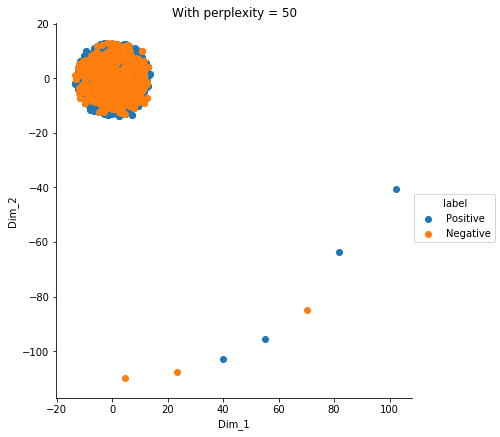

In [91]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

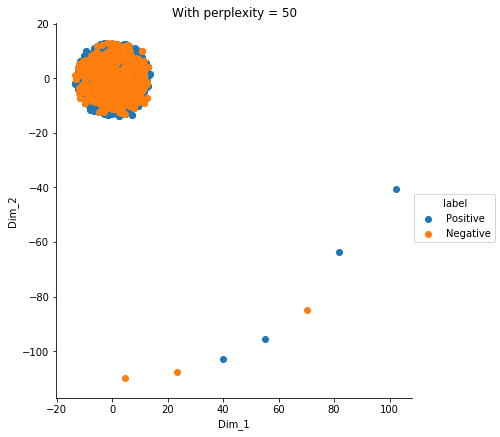

In [92]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

Observation:

We got the data in two figures, one is rounded which includes both Positive and Negative.

Rounded part is very Denser and smaller than all our previous runs.

Later, a very few pionts are formed a single line tending upwards, includes positive and Negative Points equally

Greater than 99 percent of points are centric to the Rounded part of the structure. 

This majority Chunk got located between the -18 to +18 on the Y-Axis and -20 to 20 on the X-axis

We can not find any visual difference to draw a decision surface between Positve and negative reviews.

###### Applying the TSNE on Perplexity 60

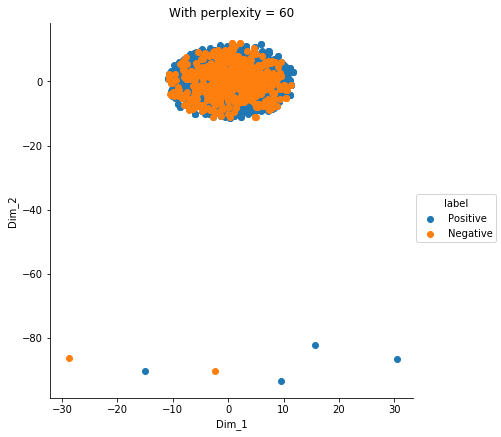

In [93]:
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

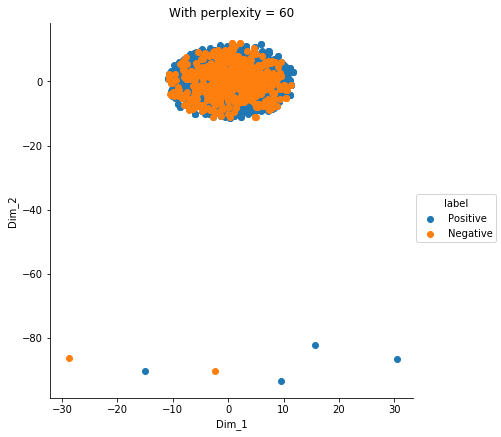

In [94]:
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=5000)
tsne_data = model.fit_transform(bog_onegrams_dense)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

Observation:

We got the data in two figures, one is Elipse which includes both Positive and Negative.

Prevoius Rounded part is now converted to Eliptical shape and low Denser and bigger than the run with perplexity = 50.

Later, a very few pionts are formed a zig-zagged scattered points and these are tending to any direction, but this includes positive and Negative Points equally

Greater than 99 percent of points are centric to the Eliptical part of the structure.

And this denser section of the data position got changed hugely from all our previous runss

This majority chunk got located between the -18 to +18 on the Y-Axis and -15 to 15 on the X-axis

We can not find any visual difference to draw a decision surface between Positve and negative reviews.

### Get the Bag Of Words for Bi-Grams

Let's create the Bag Of Words on where n_gram_range equal to 2.

To create bag of words we use CountVectorizer from sklearn.

It will results you a n-dimensional sparse Vector with the each unique word from the corpus as a dimension.

In [96]:
#For BagOfwords Bi-Grams we are getting Merror Error so we proceeding with 2000 records due the computational issues
Amazon_Data_3k = Amazon_Db.head(3000)
Amazon_Data_3k_Y = Amazon_Data_3k['Score']
print(Amazon_Data_3k.shape)

(3000, 12)


In [108]:
CountVect2 = CountVectorizer(ngram_range = (1,2))
Cvect2_Bigrams = CountVect2.fit_transform(Amazon_Data_3k['CleanReview'].values)
print(type(Cvect2_Bigrams) )
print("Size",Cvect2_Bigrams.shape)

<class 'scipy.sparse.csr.csr_matrix'>
Size (3000, 71139)


We got the Sparse Matrix with the size of 3000 x 71139

That means for all our 3000 reviews, we got the 3000 unique vectors of 71139 dimensions.

As BagOfWords are based on the occurence of a word, most dimensions in the vectors are zeor, Hence these are called sparse vectors.

In [109]:
print("the type of count vectorizer ",type(Cvect2_Bigrams))
print("the shape of out text BOW vectorizer ",Cvect2_Bigrams.get_shape())
print("the number of unique words including both unigrams and bigrams ", Cvect2_Bigrams.get_shape()[1])
print("the number of unique words including both unigrams and bigrams ", Cvect2_Bigrams[0:1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (3000, 71139)
the number of unique words including both unigrams and bigrams  71139
the number of unique words including both unigrams and bigrams    (0, 47856)	1
  (0, 3009)	1
  (0, 22492)	1
  (0, 32909)	1
  (0, 55665)	1
  (0, 37930)	1
  (0, 47776)	1
  (0, 57811)	1
  (0, 34472)	1
  (0, 35533)	1
  (0, 48011)	1
  (0, 61978)	1
  (0, 26761)	1
  (0, 24126)	1
  (0, 47945)	1
  (0, 23689)	1
  (0, 17270)	1
  (0, 9225)	1
  (0, 67580)	1
  (0, 54069)	1
  (0, 7099)	1
  (0, 5712)	1
  (0, 3000)	1
  (0, 22491)	1
  (0, 32908)	1
  (0, 55644)	1
  (0, 37909)	1
  (0, 47759)	1
  (0, 57808)	1
  (0, 33958)	1
  (0, 35438)	1
  (0, 61636)	1
  (0, 26409)	1
  (0, 24068)	1
  (0, 47830)	3
  (0, 23493)	1
  (0, 17220)	1
  (0, 9201)	1
  (0, 67579)	1
  (0, 54012)	1
  (0, 6961)	1


In [110]:
Cvect2_Bigrams_Dense = Cvect2_Bigrams.toarray()

Converted the Sparse vector to Dense Vector. lets see the shape of it now

In [115]:
print("Amazon_bigrams ", Cvect2_Bigrams_Dense.shape)
print("Shape of Amazon_bigrams ", Cvect2_Bigrams_Dense)

Amazon_bigrams  (3000, 71139)
Shape of Amazon_bigrams  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Before we Plot these words with respecitve to thier classes in the label.
Let check label classes and thier counts

In [117]:
Amazon_Data_3k_Y.value_counts()

Positive    2515
Negative     485
Name: Score, dtype: int64

In The Label we have two classes firtst one is Positive with 2515 points

and the other one is Negative with 485 points

So Here, we are trying to plot 3000 reviews with respective to their class lables.

Such that we can distinguish positive and Negative Reviews by visulizing them in 2D.

For that matter we have to reduce dimensionality of the "reviews BagOfWords Matrix" , from 3000 x 711399 to 3000 x 2

# T-SNE

In [124]:
from sklearn.manifold import TSNE

In [125]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

###### Applying the TSNE on Perplexity 5

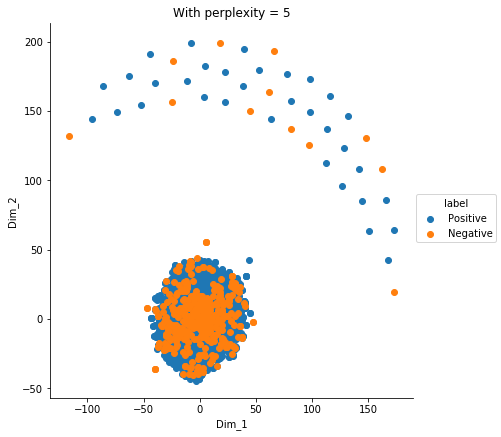

In [126]:
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

In [ ]:
#let us give try with the same preplexity 60 again

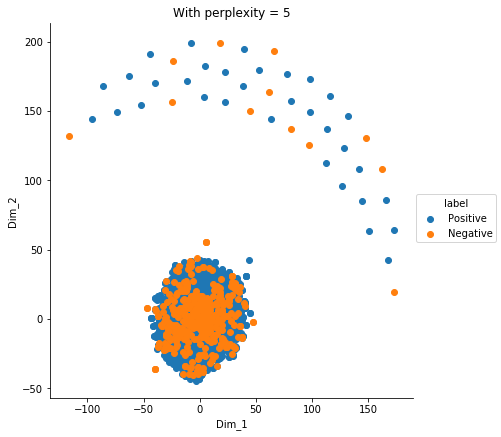

In [127]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

In [128]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 10 again

Observation:

We got the data in two figures, one is vertical Eliptical shape which includes both Positive and Negative.

Later, a very few pionts are formed four curved lines tending Downwards, includes positive and Negative Points equally, this includes positive and Negative Points equally

Eliptical part is very Denser and smaller than all our previous runs.

Greater than 99 percent of points are centric to the Eliptical part of the structure.

This majority chunk got located between the -50 to +50 on the Y-Axis and -50 to +50 on the X-axis

We can not find any visual difference to draw a decision surface between Positve and negative reviews.

##### Applying the TSNE on Perplexity 10

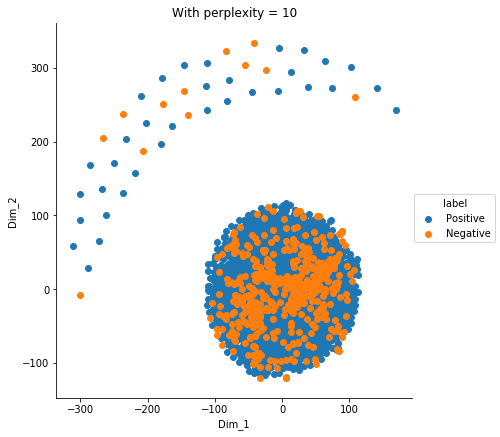

In [129]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

In [130]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 10 again

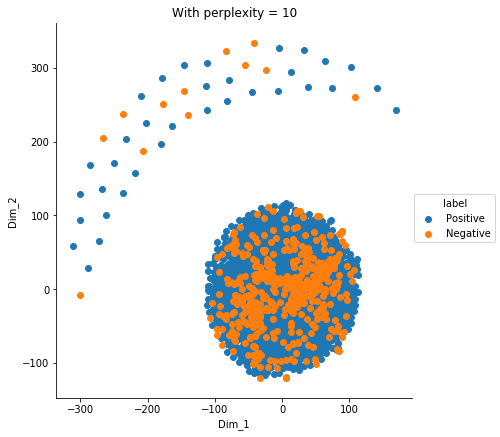

In [131]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

Observation:

We got the data in two figures, one is almost Round shape which includes both Positive and Negative.

Prevoius Eliptical shape part is now converted to almost Round shape and low Denser and bigger than the run with perplexity = 5.

Later, a very few pionts are formed four curved lines tending upwards- started and ending with downwaards.

Rounded part is very Denser and smaller than all our previous runs.

Greater than 99 percent of points are centric to the Eliptical part of the structure.

This majority chunk got located between the -150 to +50 on the Y-Axis and -100 to +100 on the X-axis

We can not find any visual difference to draw a decision surface between Positve and negative reviews.


In [132]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 20 again

###### Applying the TSNE on Perplexity 20

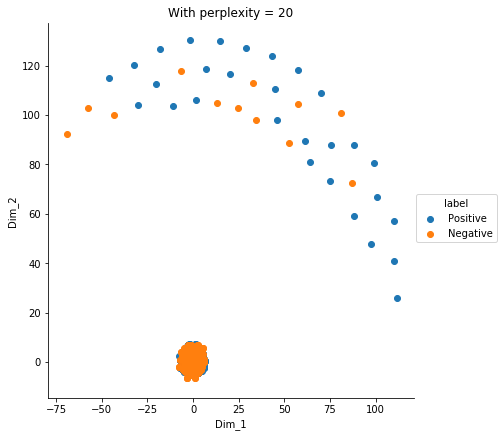

In [133]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

In [134]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 20 again

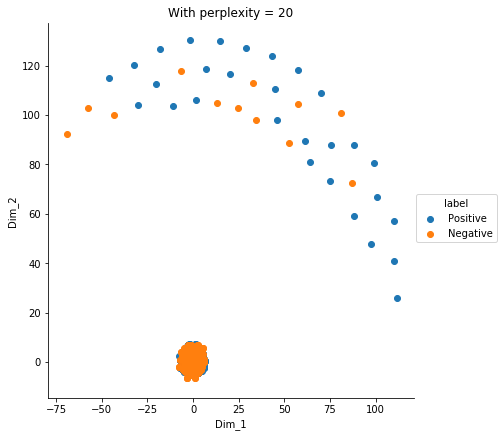

In [135]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

In [136]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 30 again

Observation:

We got the data in two figures, one is Round shape which includes both Positive and Negative.

Prevoius Denser round shape part is now converted to Denser Round shape and very very high Denser and very smaller than the previous run.

Later, a very few pionts are formed Three curved lines tending Downwards- started 

Rounded part is very Denser and smaller than all our previous runs.

Greater than 99 percent of points are centric to the Rounded part of the structure.

This majority chunk got located between the -18 to +18 on the Y-Axis and -10 to +10 on the X-axis

Another imoportant catch is Negative points sparse more than Positive as a result we are able to visualize Negative points more than Positives

We can not find any visual difference to draw a decision surface between Positve and negative reviews.

###### Applying the TSNE on Perplexity 30

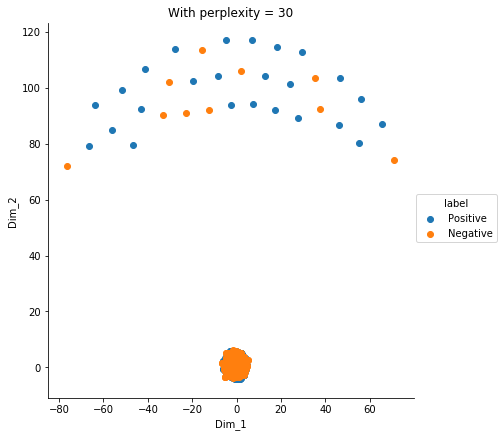

In [137]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

In [138]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 30 again

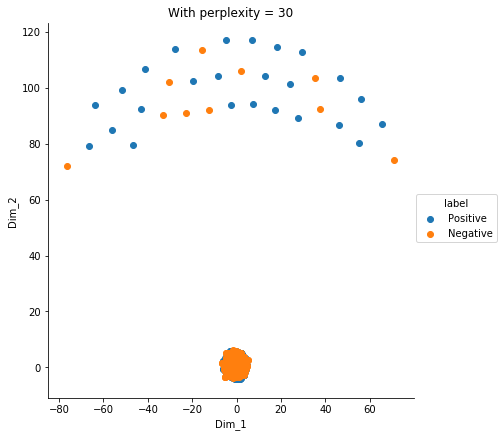

In [139]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

Observation:

This is almost equal to the output of the perplexity= 30

###### Applying the TSNE on Perplexity 40

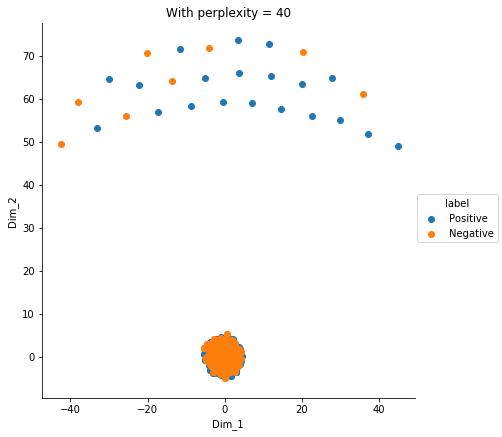

In [140]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

In [141]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 40 again

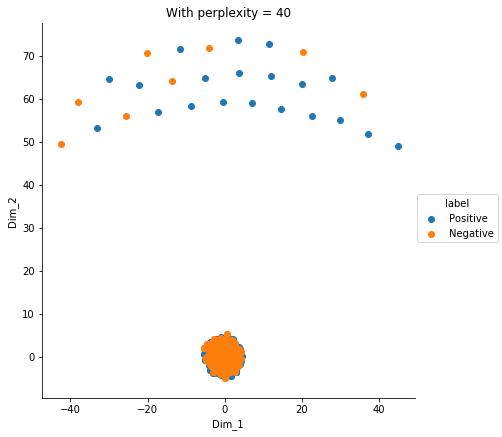

In [143]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

In [144]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 40 again

Observation:

This Output is almost equivalent to the previous Output.

But then only difference is this output is litle sparser than previous

###### Applying the TSNE on Perplexity 50

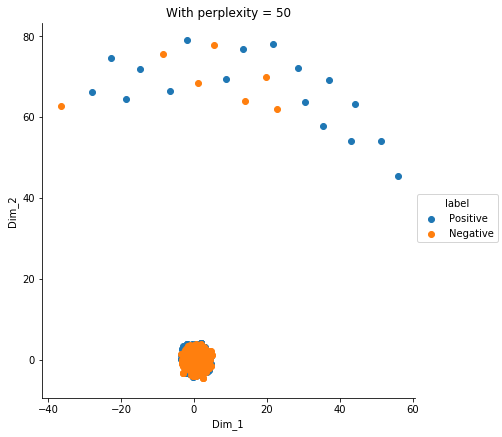

In [145]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

In [146]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 60 again

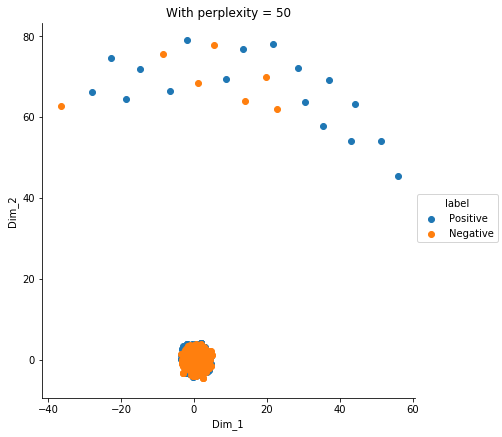

In [147]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

In [148]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 60 again

Observation:

This is almost equal to the output of the perplexity= 40.

No change is noticed

###### Applying the TSNE on Perplexity 60

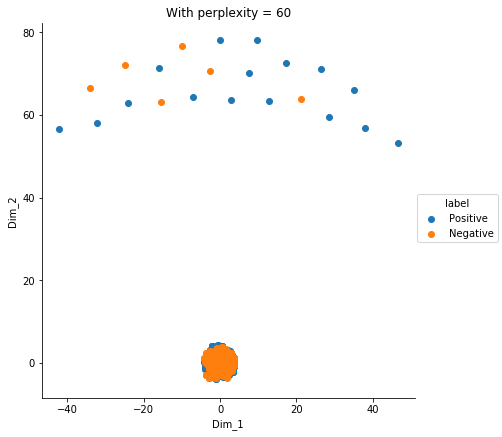

In [149]:
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

In [150]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 60 again

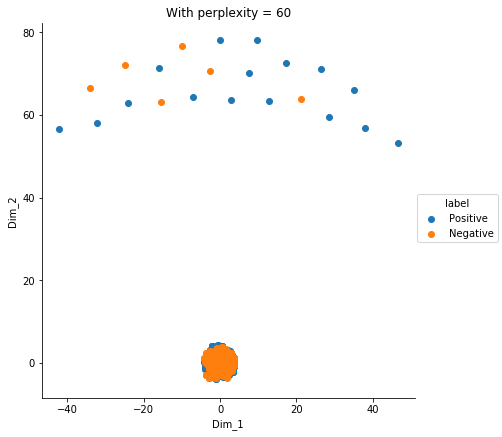

In [151]:
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=3000)
tsne_data = model.fit_transform(Cvect2_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

In [152]:
#bog_onegrams_dense = bog_onegrams.toarray() print("Amazon_bigrams >>", bog_onegrams_dense)  
#let us give try with the same preplexity 60 again

Observation:

This is almost equal to the previous output.

No change is noticed.

### TF-IDF

Term Frequency-Inverse Document Frequency

In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [154]:
TfidfVector  = TfidfVectorizer()
Tfidf_Data = TfidfVector.fit_transform(Amazon_Db['CleanReview'].values)
Tfidf_Data_Unigrams_Dense = Tfidf_Data.toarray()

We have generated a Tf-Idf vector. 

For each word we got a Tf-Idf value, like wise for each review we have a tf-idf vecotor.

Let us set the Tsne plots below, for different perplexity.

Applying the Perplexity 5, plotting on top of two features from the Tfidf vector.
  

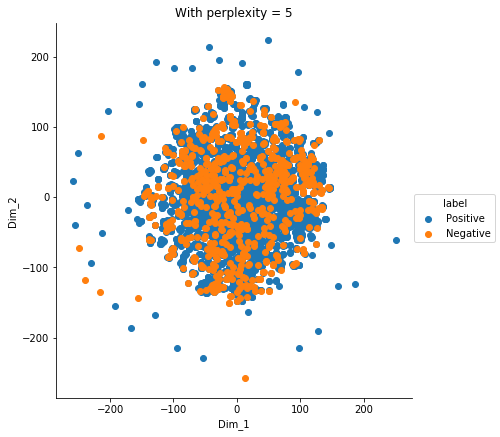

In [155]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

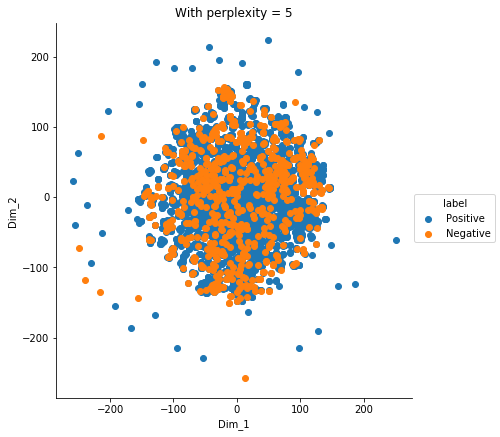

In [156]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

Observation:
    
Points are very Denser and forming a densed round with both positive and negative points.
    
Aroud this densed structre a few points are rounded like cyclic pattern
    
We could not draw a boundary surface for the above plot

###### Applying the TSNE on Perplexity 10

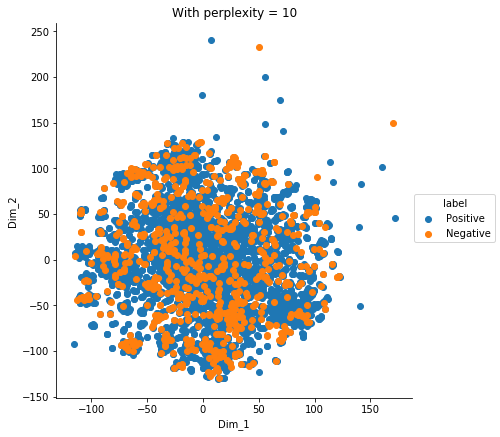

In [157]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

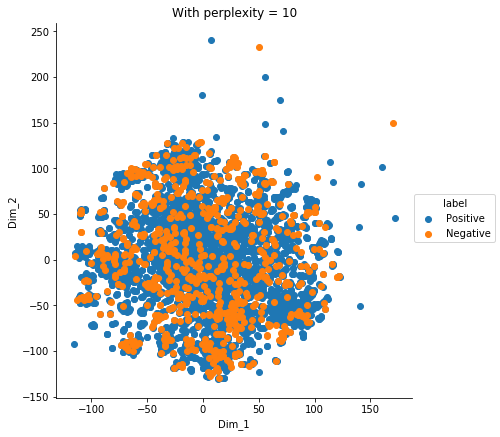

In [158]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

Observation:

Points are Denser but compared to the prevoius plot points are little Sparsed.
   
We dont find any cyclic patterns, around the majority densed structure which we have seen in the pervous plot.
    
We could not draw a boundary surface for the above plot

###### Applying the TSNE on Perplexity 20

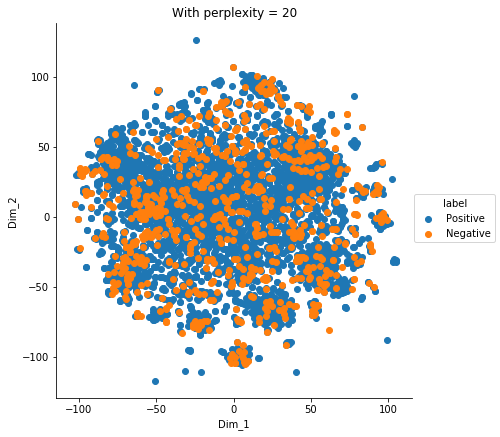

In [159]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

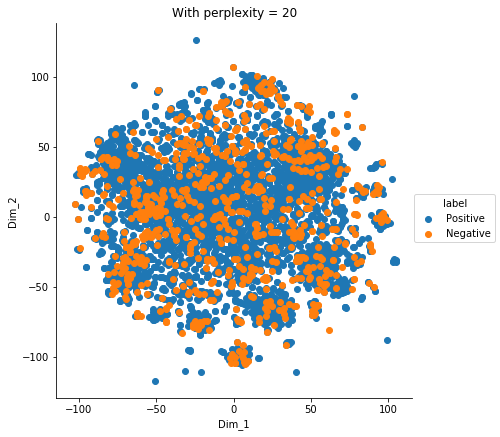

In [160]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

Observation:

Points are Sparsed but not highly scattered.

We could not draw a boundary surface for the above plot.

###### Applying the TSNE on Perplexity 30

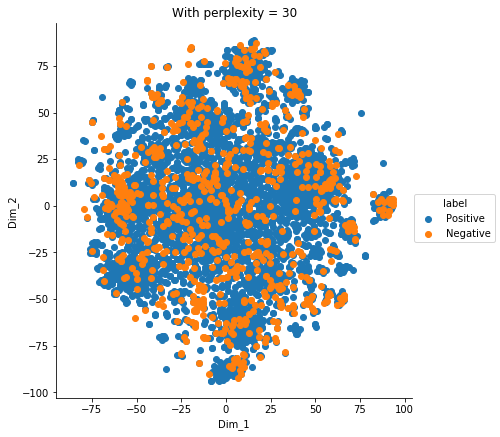

In [161]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

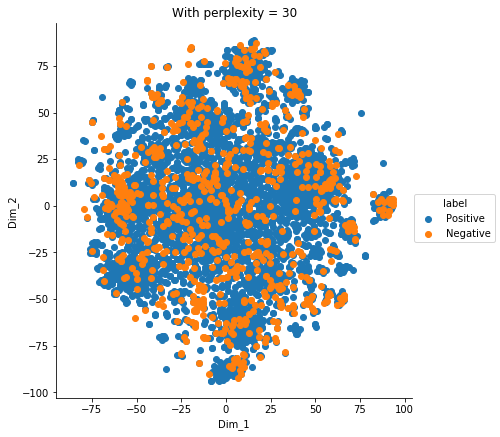

In [162]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

Observation:

Points are Sparsed but compared to the previous plot this time it got densed.

We could not draw a boundary surface for the above plot.


###### Applying the TSNE on Perplexity 40

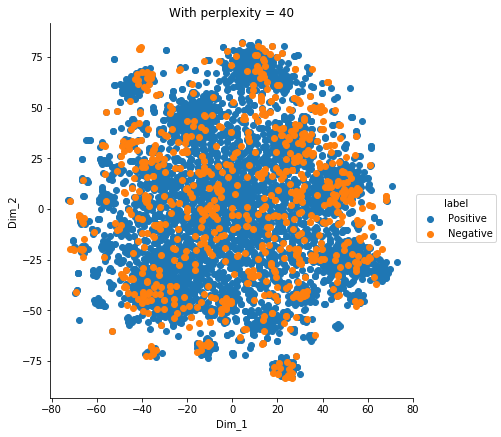

In [163]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

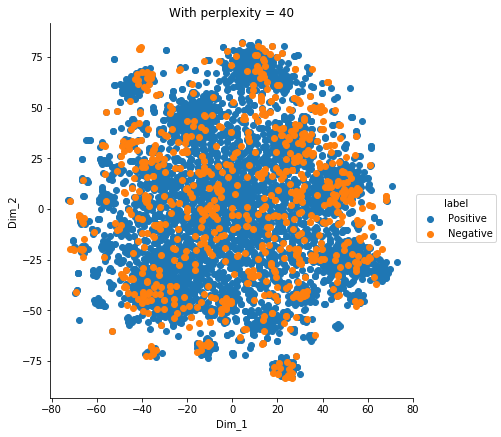

In [164]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

###### Applying the TSNE on Perplexity 50

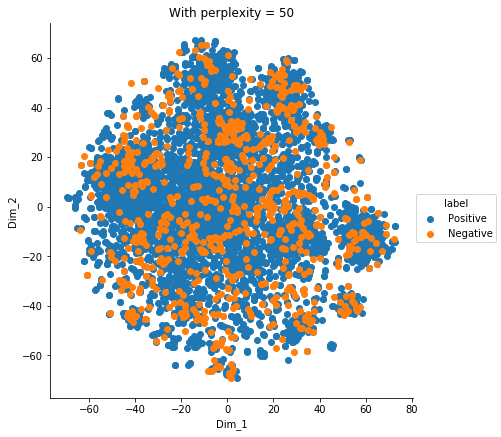

In [165]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

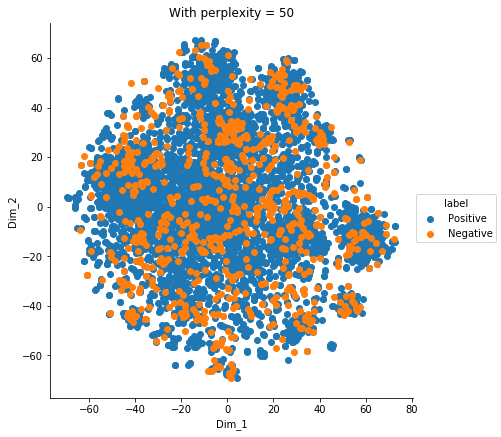

In [166]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

Observation:

Highly Sparsed( scatterness) in this structure compared to the prevous all plots.

Data points are expanding vertically.

We could not make any seperation to review points 

###### Applying the TSNE on Perplexity 60

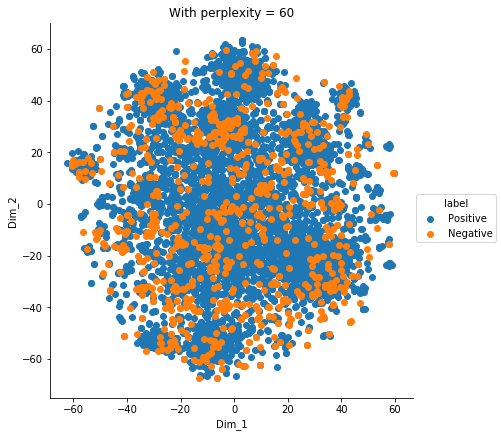

In [167]:
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

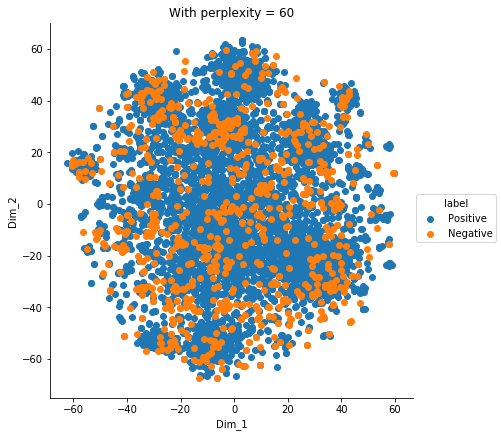

In [168]:
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Unigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Db['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

Observation:

This is just like the prevoious with a little more scatteredness.

We could not make any seperation to review points

### Tf-Idf with Bi-grams

In [169]:
TfidfVector  = TfidfVectorizer(ngram_range = (1,2))
Tfidf_Data_2 = TfidfVector.fit_transform(Amazon_Data_3k['CleanReview'].values)
Tfidf_Data_Bigrams_Dense = Tfidf_Data_2.toarray()

We have generated a Tf-Idf vector with BiGrams(ngrams equal to 2).

For each sequential pair of words,  we got a single Tf-Idf value, like wise for each review we have a tf-idf vecotor.

Let us set the Tsne plots below, for different perplexity.


##### Applying the TSNE on Perplexity 5

Applying the Perplexity 5 with n_iter equal to 3000, plotting on top of two features from the Tfidf vector.

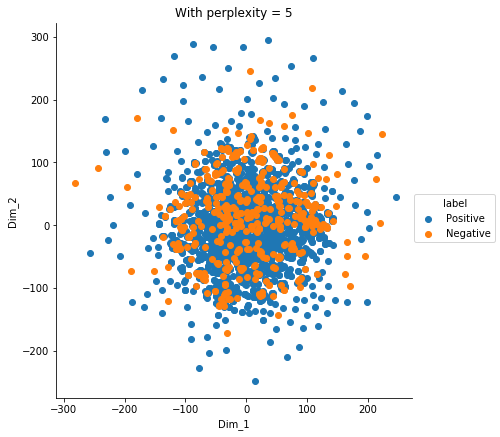

In [170]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

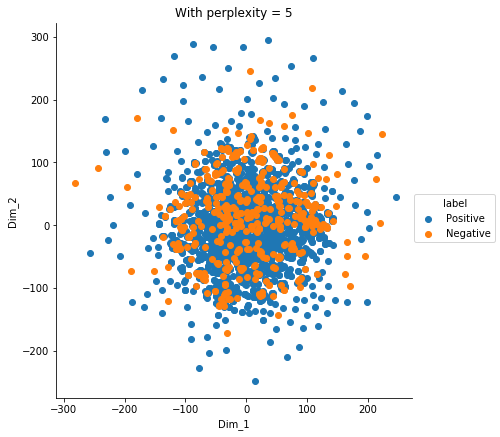

In [171]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

Observation:

As per the above graph, points are tending towards the centre of cicle type structure. 

Most of the data points closly 98% of data existed inside the circle. And remaining are distributed around this densed circle.

Point that are out side the circle are distributed sparsely.

We have no clear way to draw a boundary surface for this plot.
    

###### Applying the TSNE on Perplexity 10

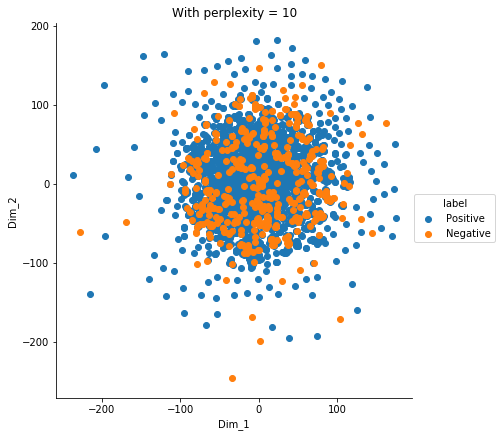

In [172]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

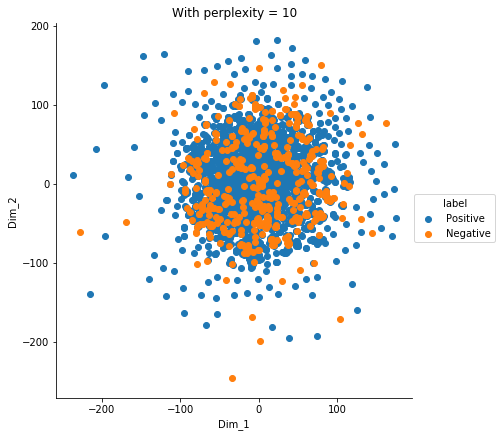

In [173]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

Observation:

Data points got densed and shifted towards the centre of the circle.

##### Applying the TSNE on Perplexity 20

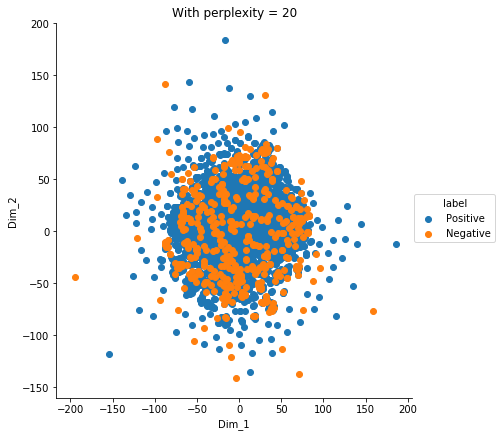

In [174]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

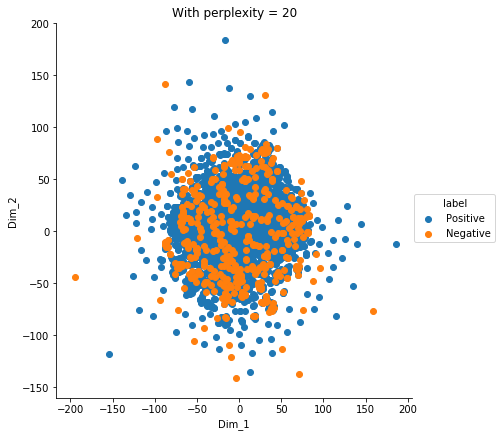

In [175]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

# Observation:

Data points got densed and shifted towards the centre of the circle.

We also can sparsed points outside the core-concentric circle is tending in the downwards and showing as verically elasted.

No way to draw a boundary surface for this plot

##### Applying the TSNE on Perplexity 30

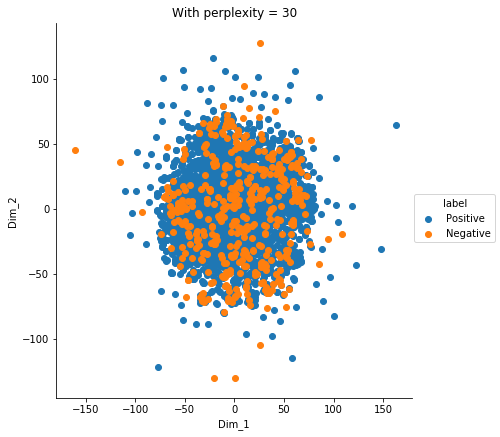

In [176]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

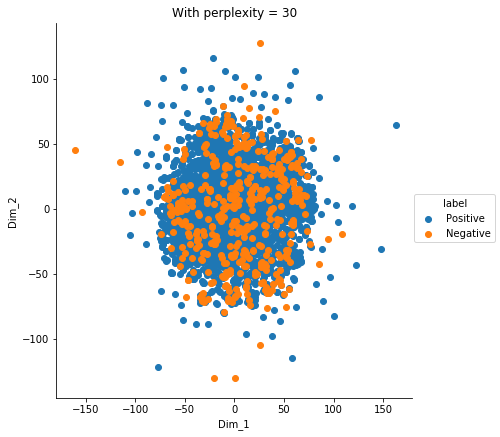

In [177]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

Observation:

Data points got densed than the prevoius and shifted towards the centre of the circle.

We also can see sparsed points which are outside the  circle is tending in the centre of the circle.

No way to draw a boundary surface for this plot.

##### Applying the TSNE on Perplexity 40

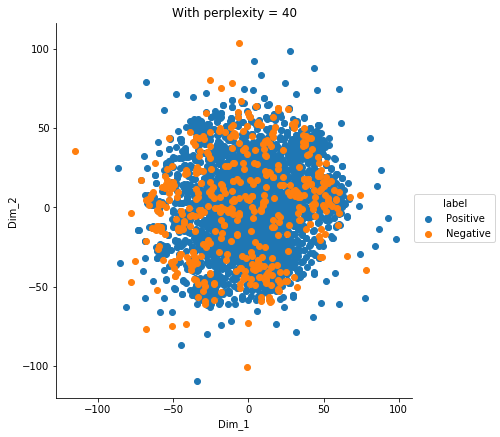

In [178]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

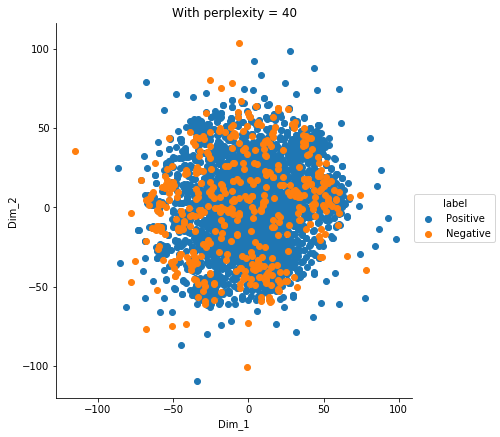

In [179]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

##### Applying the TSNE on Perplexity 50

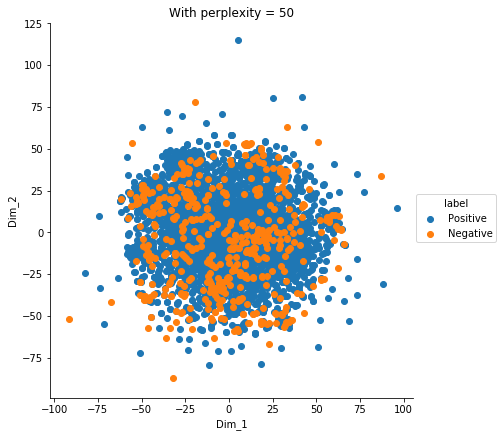

In [180]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

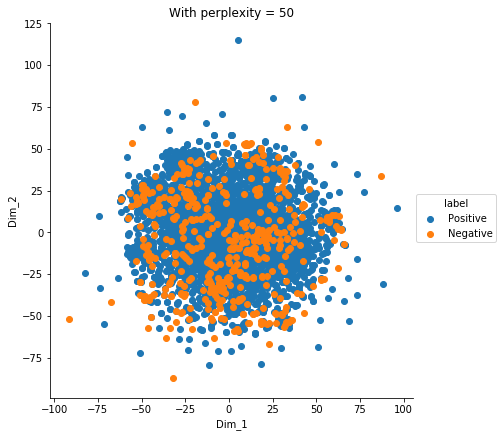

In [181]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

Observation :

The graph for the perplexity = 50, almost equal to the perplexity = 60.

Data points are slightly Denser but the overall shape is stable.

Still, we are unable to find the boundary surface between the points.

###### Applying the TSNE on Perplexity 60

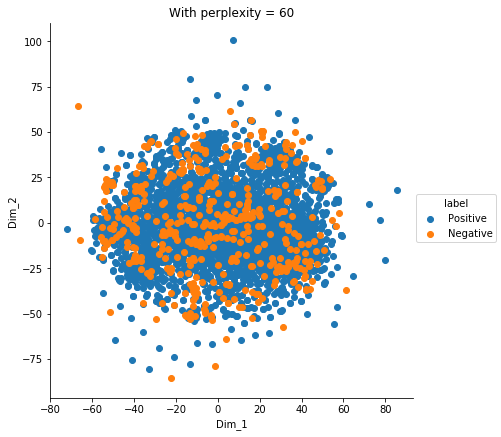

In [182]:
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

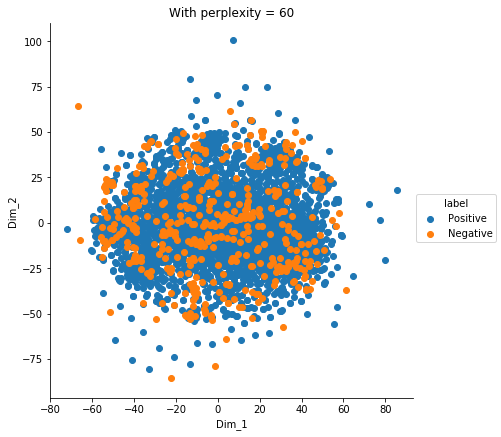

In [183]:
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=3000)
tsne_data = model.fit_transform(Tfidf_Data_Bigrams_Dense)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data_3k['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 60')
plt.show()

Observation :

Data points are started getting wider.

Still, we are unable to find the boundary surface between the points.

### W2V -Word to Vector

Let us consider all the unique words from each document/review and create a Corpus

With the help of Gensim we convert a word into d-dimensional vector.

If the exists n words in a review, we will get 'n' no of d-dimensional vectors


### Avg W2V

In order to generaate a Single vector per each review, we Average all the review from the 'n' of  d-dimensional vectors.

Before generating the Word2Vec, Let us extract the words from the Dataframe 'CleanReview' 

In [198]:
Words_list_from_reviews = [] #Amazon_Data['CleanReview']

for sentene in Amazon_Data['CleanReview'].values:
    Words_list_from_reviews.append(sentene.split())
len(Words_list_from_reviews)


5000

In [259]:
from gensim.models import Word2Vec
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(Words_list_from_reviews,min_count=7,size=250, workers=4)

In [274]:
print("Type        :",w2v_model)
print("Length      :",len(w2v_model.wv.vocab))
print("Vector size :",w2v_model.vector_size)

Type        : Word2Vec(vocab=2219, size=250, alpha=0.025)
Length      : 2219
Vector size : 250


We have taken each and every word which has occured more than seven times in the entire review corpus

Created a word2Vector

We got 2219 words each having the dimension of 250.

Let us check the vector for a word like 'tasti'.

For just a single word 'tasti' we got 250 dimensional vecotrs

In [288]:
w2v_words = list(w2v_model.wv.vocab)


'w2v_model.wv.vocab' is Dictionary with each word as key and its word2vec generated Vector as its respective value.

We have converted this dictionary to a list for our further processing.


In [301]:
Total_Sentence_Vecors = []

for sent in Words_list_from_reviews:
    Each_Sent_Vect = np.zeros(250)
    count_words = 0
    for word in sent:        
        if word in w2v_words:
            vect = w2v_model.wv[word]
            Each_Sent_Vect += vect 
            count_words += 1
    if count_words > 0:
        Each_Sent_Vect /= count_words
    Total_Sentence_Vecors.append(Each_Sent_Vect)
print("length of total avg word2vec ", len(Total_Sentence_Vecors))

length of total avg word2vec  5000


Observation:

We have 5000 reviews, for each word we have 250 dimensional vector, like wise we may have mulitple words for a single review. 

So we have Averaged all the vectors of the words in a single sentence.

Finallly, we have final list for the entire reviews. It is a list of lists.

In [306]:
type(Total_Sentence_Vecors)

list

###### Applying TSNE on top of Word2Vect Vectors

###### Tsne - with preplexity 5

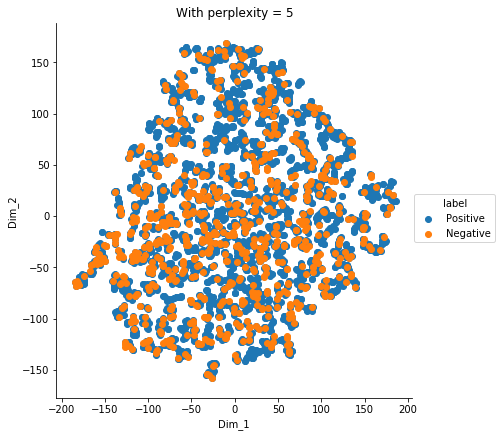

In [313]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

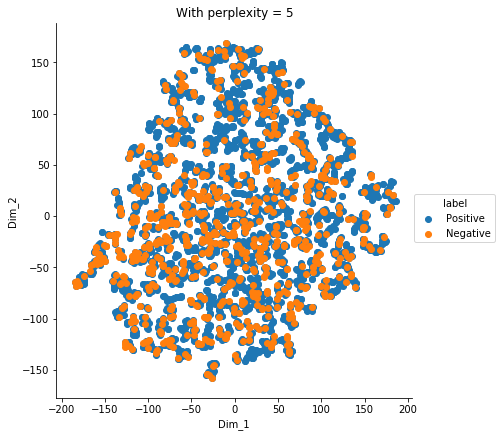

In [314]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

Observations:

Data points are highly Sparsed

Many tiny clustters which includes both positive and negative points


##### Tsne - with preplexity 10

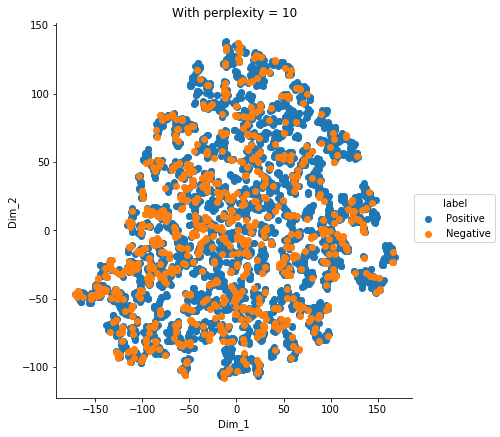

In [315]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

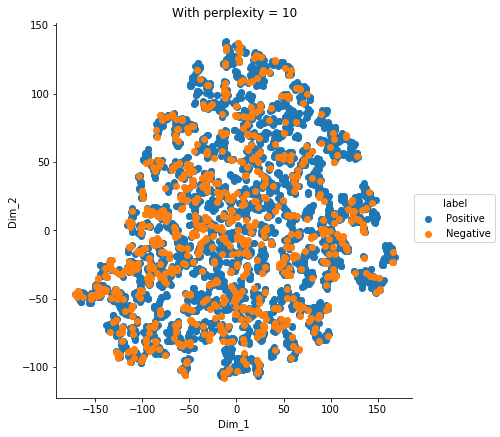

In [316]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

In [ ]:
Observation:

No, Much difference from the plot with perplexity 5.

###### Tsne - with preplexity 20

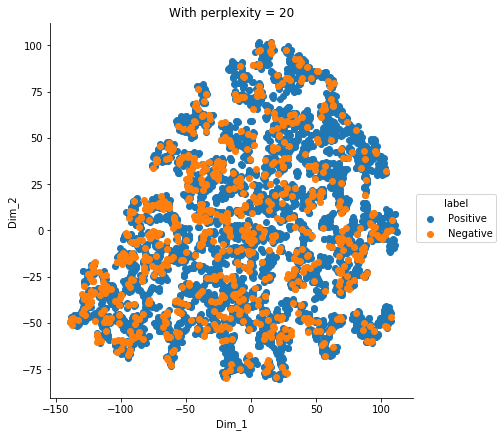

In [317]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

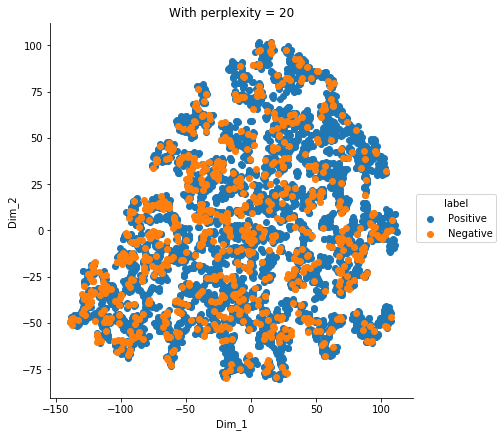

In [318]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

Observations:

Comparitivly the Data points are highly Densed, But still it Sparsed in general.


###### Tsne - with preplexity 30

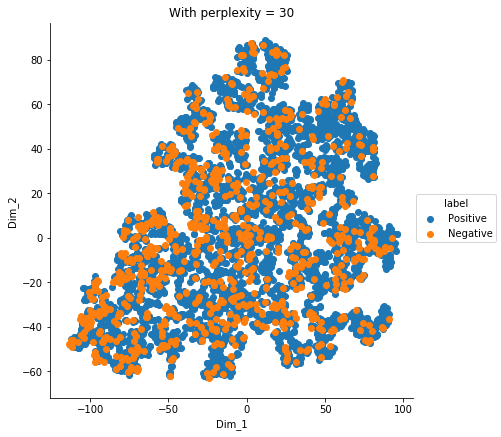

In [319]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

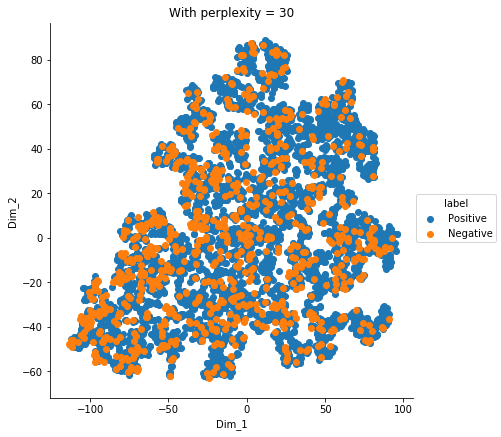

In [320]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

Observation:

No much difference Noticed

###### Tsne - with preplexity 40

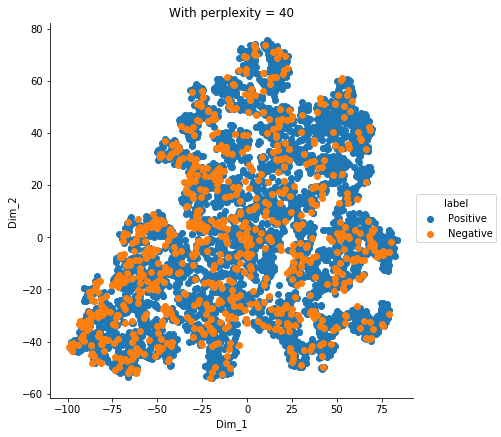

In [321]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

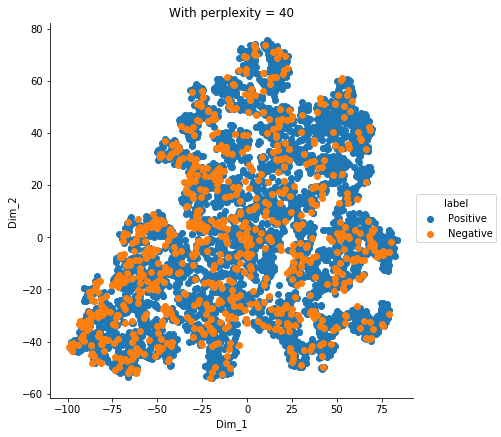

In [322]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

###### Tsne - with preplexity 50

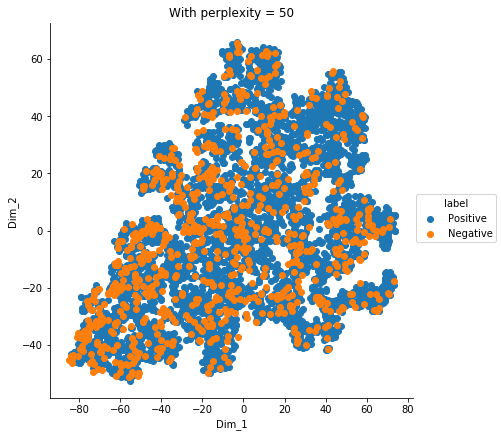

In [323]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

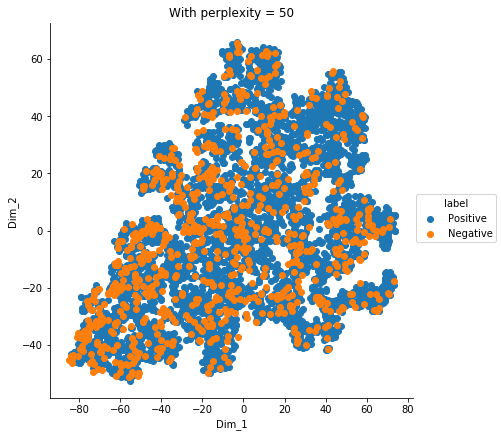

In [324]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(Total_Sentence_Vecors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

Observations:

Comparitivly the Data points are Densed, But no particular shape.

we can also notice the tiny clusters got reduced.

#### TFIDF-Word2Vect

In [353]:
TfidfVector  = TfidfVectorizer(min_df=7)
model = TfidfVector.fit_transform(Amazon_Db['CleanReview'].values)

In [340]:
print(len(TfidfVector.get_feature_names()))
print(len(TfidfVector.idf_))

7719
7719


We generatred TFidf Vector for the word which got occured atleast for seven times in the corpus.

Using TfidfVector.get_feature_names we got all words in the tfidf-vector.

TfidfVector.idf_ is a method to pull off the score of each feature/word.

By this we are able to construct the dictionary with the key-value pair as  word and its tfidf value


In [352]:
#dict(zip(TfidfVector.get_feature_names(),np.zeros(len(TfidfVector.get_feature_names()))))
Tfidf_Dict = dict(zip(TfidfVector.get_feature_names(),TfidfVector.idf_))

In [376]:
w = 'absolutley'
print(Tfidf_Dict[w])

8.824245990858959


In [ ]:
sentence_vectors = [];                # the avg-w2v for each sentence/review is stored in this list
for sent in Words_list_from_reviews: # for each review/sentence
    sent_vec = np.zeros(250)        # as word vectors are of zero length
    count_words =0;               # num of words with a valid vector in the sentence/review
    for word in sent:           # for each word in a review/sentence
        if word in w2v_words:
            tf_idf_val = Tfidf_Dict[word]
            vec = w2v_model.wv[word]
            sent_vec += (vec * tf_idf_val)
            count_words += 1
    if count_words != 0:
        sent_vec /= count_words
    sentence_vectors.append(sent_vec)
print(len(sentence_vectors))

Now, let us plott TSNE on top of generated vectors for all the reviews.

We provide the Socre - label to TSNE to figure out the Positive or Negative type of the given vector.

He in the below, we have started plotting our TSNE with Perplexity equal to 5.

For each perplexity we will try to give a multiple runs.

###### Tsne - with preplexity 5

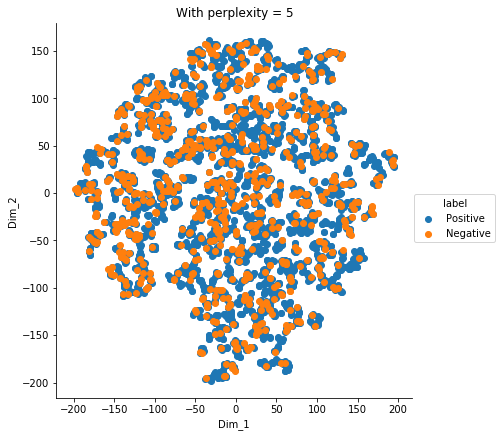

In [361]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

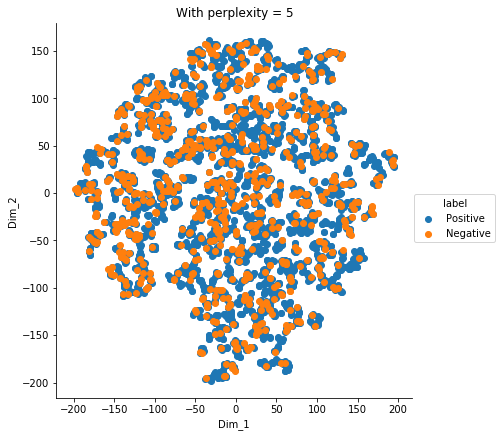

In [363]:
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

Observation:

We are able to notice positive and Negative Reviews in the about visualization.

Data points are very sparsed. Can find so many internal groups of negative and positve.

But we counld not draw any Boundary surface to differentiate the two polarities.

So let's keep on trying with multiple Perplexities.

###### Tsne - with preplexity 10

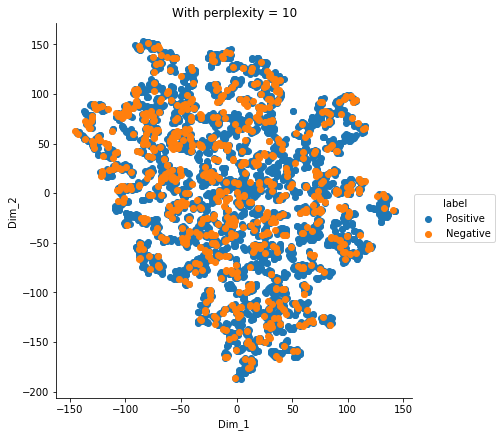

In [364]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

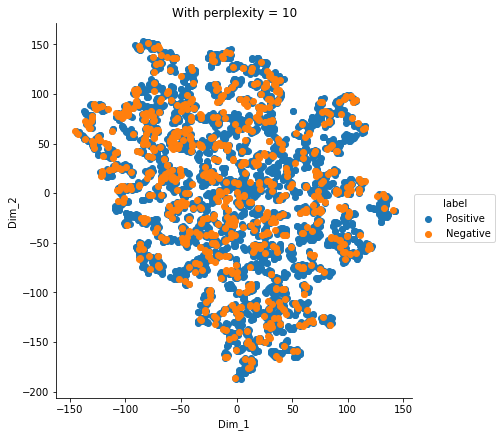

In [365]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

Observations:

Data paints getting bit sparased.

###### Tsne - with preplexity 20

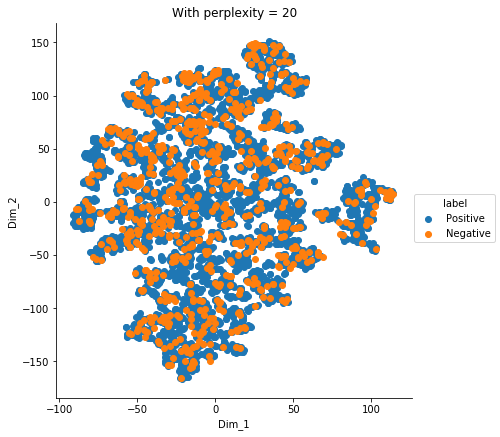

In [366]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

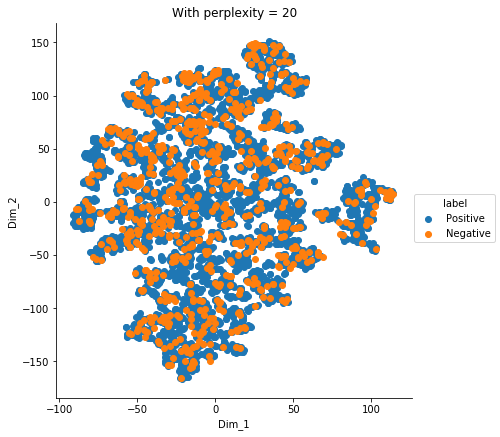

In [367]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 20')
plt.show()

Observation:
Data points are getting closer.

###### Tsne - with preplexity 30

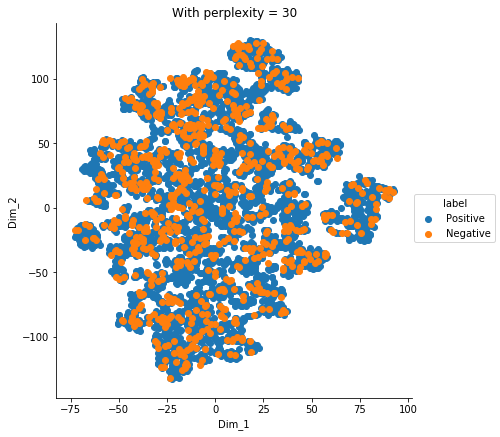

In [368]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

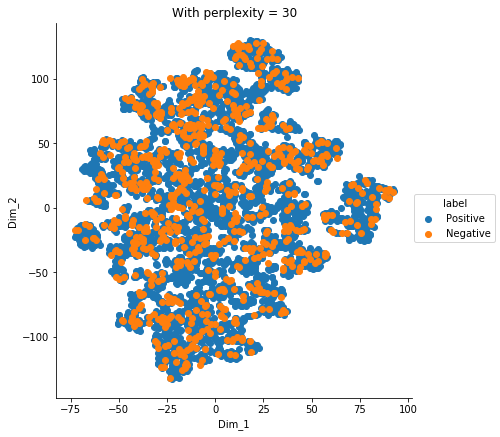

In [369]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

Observation : We can Observe Even more closer than perplexity 20

###### Tsne - with preplexity 40

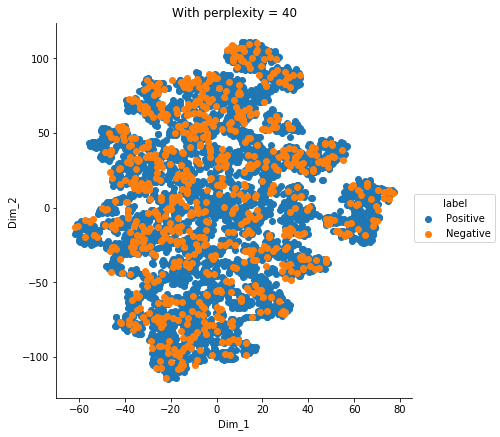

In [370]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

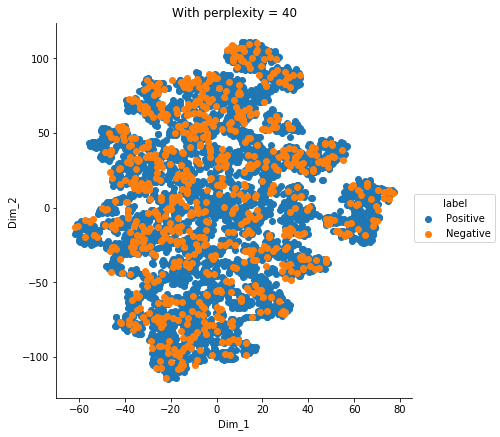

In [371]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 40')
plt.show()

###### Tsne - with preplexity 50

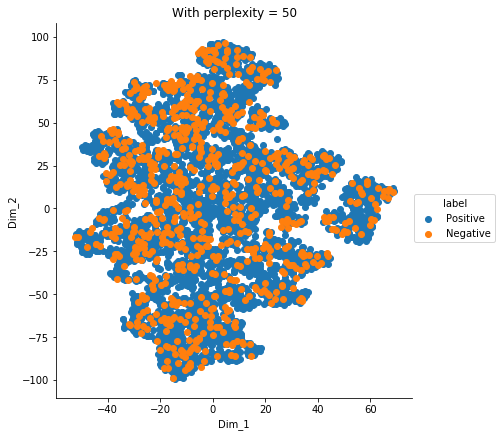

In [372]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(sentence_vectors)
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Amazon_Data['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

Observation:
Data points are even more Dened.

On a whole we are unable to seperate the data points with respective to its labels.

###### Summary

We could not make a boundary surface in our exiperiments.

Here we are only plotting 5000 points, but we can imporve better if we could workout with entire Dataset.
